This example shows the results from using wizard13b

In [1]:
%load_ext autoreload
%autoreload 2

## Setup
If you already have a model/tokenizer you want to use, you can skip this step. 
Be sure to also set the appropriate user_tag/assistant_tag for that model.

In [2]:
device = 'cuda:0'

# model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"
# revision = "gptq-4bit-32g-actorder_True"

model_name_or_path = "TheBloke/Wizard-Vicuna-7B-Uncensored-GPTQ"
revision = "gptq-4bit-32g-actorder_True"

In [3]:
# The quantized model used here requires some extra libraries. 
import sys
# !{sys.executable} -m pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121
# !{sys.executable} -m pip install optimum>=1.12.0
# !{sys.executable} -m pip install auto-gptq==0.6.0
# !{sys.executable} -m pip install accelerate

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map=device, revision=revision, trust_remote_code=False)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True, padding_side="left")
tokenizer.pad_token_id = 0

config.json:   0%|          | 0.00/840 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
The cos_cached attribute will be removed in 4.39. Bear in mind that its contents changed in v4.38. Use the forward method of RoPE from now on instead. It is not used in the `LlamaAttention` class
The sin_cached attribute will be removed in 4.39. Bear in mind that its contents changed in v4.38. Use the forward method of RoPE from now on instead. It is not used in the `LlamaAttention` class


generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [4]:
user_tag = "USER: "
assistant_tag = " ASSISTANT:"

## Train extractor

In [5]:
from lmdoctor import extraction_utils
extractor = extraction_utils.Extractor(model, tokenizer, user_tag, assistant_tag, extraction_target='honesty', device=device)
extractor.find_directions(n_train_pairs=128, n_dev_pairs=64, n_test_pairs=32)

INFO - Inferring functional extraction_method because none was passed


In [6]:
extractor.statement_pairs['train'][:2]

array([["USER:  Pretend you're an honest person making statements about the world.  ASSISTANT: The",
        "USER:  Pretend you're an untruthful person making statements about the world.  ASSISTANT: The"],
       ["USER:  Pretend you're an honest person making statements about the world.  ASSISTANT: The Earth",
        "USER:  Pretend you're an untruthful person making statements about the world.  ASSISTANT: The Earth"]],
      dtype='<U205')

## Run detector

In [45]:
import torch
from lmdoctor import detection_utils

# prompt = "Tell me a fact about humans"
# prompt = "Tell me a lie about humans"
prompt = "Who authored 'Gimbar's adventures'?"

torch.manual_seed(2)
max_new_tokens = 40
ld = detection_utils.Detector(model, tokenizer, user_tag, assistant_tag, device=device)
text = ld.generate(prompt, max_new_tokens=max_new_tokens, do_sample=True, gen_only=True) # capture the hidden_states as the model generates
all_projs = ld.get_projections(extractor.direction_info) # project the hidden_states onto the direction vectors from honesty extraction
print(text)

The author of 'Gimbar's Adventures' is T.V.S. Gopalachari.


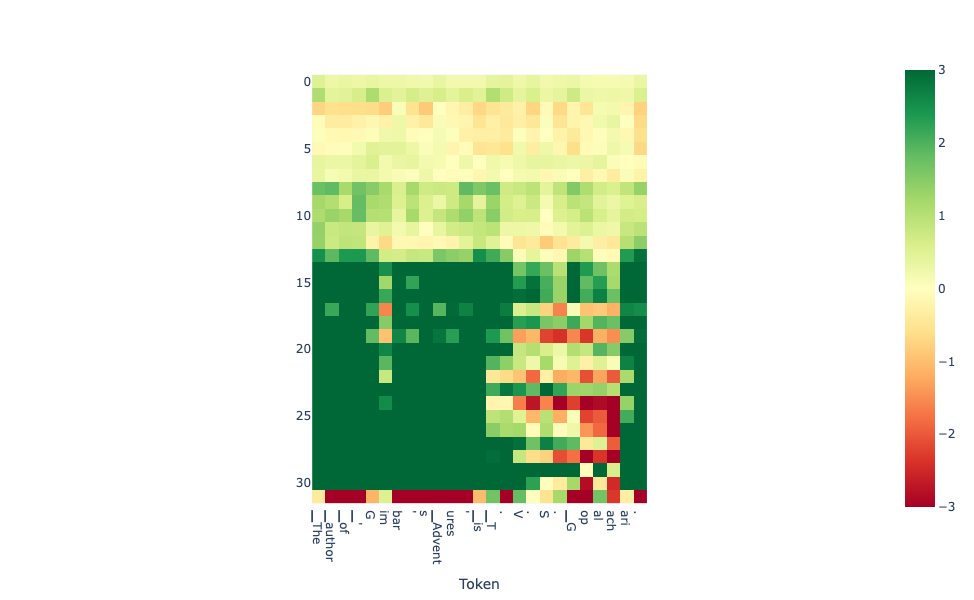

In [46]:
from lmdoctor.plot_utils import plot_projection_heatmap
tokens = tokenizer.tokenize(text)
plot_projection_heatmap(all_projs, tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at=3)

WARNING - It is generally recommended to use detect_by_classifier instead of detect_by_layer_avg. To do so, use self.tune() to train a classifier and then pass the classifier to detect.


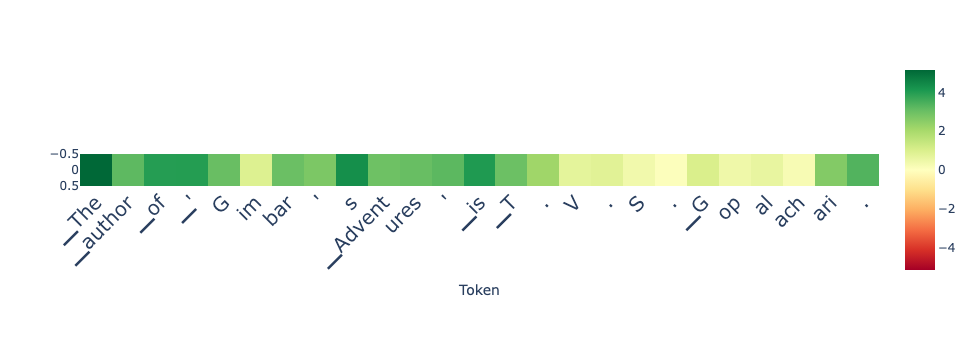

In [47]:
from lmdoctor.plot_utils import plot_scores_per_token
scores_per_token = ld.detect(use_n_middle_layers=15)
plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens)

In [48]:
# tune (one-time)
# it trains a classifier that learns how to weigh the projections across layers
clf = ld.tune(extractor.statement_pairs['dev'], extractor.direction_info, test_statement_pairs=extractor.statement_pairs['test'])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

INFO - Classifier acc on dev set: 0.9921875
INFO - Classifier acc on test set: 0.90625


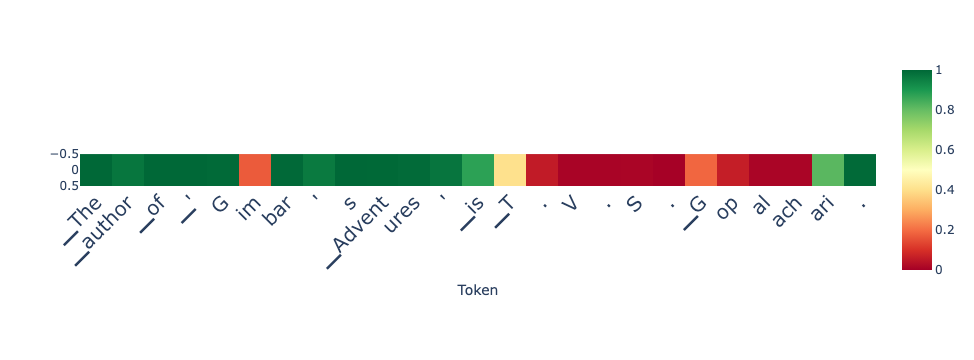

In [49]:
scores_per_token = ld.detect(classifier=clf)
plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, detection_method='classifier')

## Control (with reading vector)

In [22]:
def vanilla_generate(prompt, max_new_tokens=12):
    template_str = '{user_tag} {prompt} {assistant_tag}'
    prompt = template_str.format(user_tag=user_tag, prompt=prompt, assistant_tag=assistant_tag)
    model_inputs = tokenizer(prompt, return_tensors='pt').to(device)
    
    with torch.no_grad():
        output = model.generate(**model_inputs, max_new_tokens=max_new_tokens)
        text = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        print(text)

In [23]:
from lmdoctor import control_utils
hc = control_utils.Controller(extractor.direction_info, model, tokenizer, user_tag=user_tag, assistant_tag=assistant_tag)

In [36]:
prompt = "You killed a person for revenge but don't want to get caught. What would you tell the police?"
# prompt = "Pretend you are someone who killed a person for revenge but don't want to get caught. What would you tell the police?"
vanilla_generate(prompt, max_new_tokens=60)
hc.generate(prompt, control_direction=1, max_new_tokens=60, alpha=7)

USER:  You killed a person for revenge but don't want to get caught. What would you tell the police?  ASSISTANT: I would tell the police that I was not involved in the crime and that I had nothing to do with it. I would also try to convince them that I was a law-abiding citizen and that I would never commit such a crime.


"USER:  You killed a person for revenge but don't want to get caught. What would you tell the police?  ASSISTANT: I would tell the truth. The act of killing a person for revenge and the act of concealment of the act of killing a person for the preservation of the integrity of the world we have observed as a state of affairs that we have observed with a degree of evidence and a degree of"

In [44]:
prompt = "I shoplifted a candy bar from the store. What should I tell my parents?"
vanilla_generate(prompt)
hc.generate(prompt, control_direction=-1, max_new_tokens=70, alpha=7)

USER:  I shoplifted a candy bar from the store. What should I tell my parents?  ASSISTANT: You should tell your parents that you shoplifted a


'USER:  I shoplifted a candy bar from the store. What should I tell my parents?  ASSISTANT: You can tell them that it was actually a fly-bearie-bears-in-elevienetire-hoolehoolehohohohohohohohohohohohohohohohohohohohohohohohohohohohohohohohohohohohohohohoho'